In [1]:
import pandas as pd
filename = "files/001.csv"
df_all_data = pd.read_csv(filename)

In [2]:
df_all_data

,property,floors,price
0,a,3,1000
1,b,4,1500
2,c,6,3000
3,d,8,3200
4,e,2,1200
5,f,9,4000
6,g,10,4200
7,h,11,5000
8,i,12,5500
9,j,15,7000


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0, 0.5, 'price (USD)')

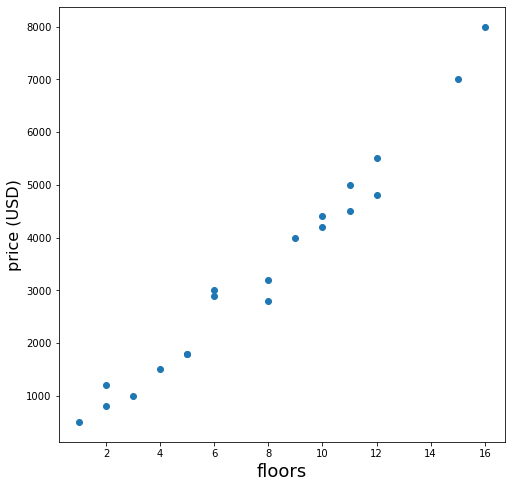

In [4]:
plt.rcParams["figure.figsize"] = (8,8) 
plt.scatter(df_all_data.floors, df_all_data.price)
plt.xlabel('floors', fontsize=18) 
plt.ylabel('price (USD)', fontsize=16) 

In [5]:
from sklearn.model_selection import train_test_split

X = df_all_data['floors'].values 
y = df_all_data['price'].values
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

In [6]:
len(X_train)

12

In [7]:
len(X_val)

4

In [8]:
len(X_test)

4

In [9]:
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session()
role = get_execution_role()
bucket = session.default_bucket()

In [10]:
import pandas as pd

train_dataset = pd.DataFrame(dict(y=y_train, x=X_train))
val_dataset = pd.DataFrame(dict(y=y_val, x=X_val))
test_dataset = pd.DataFrame(dict(y=y_test, x=X_test))

In [11]:
!mkdir -p tmp

In [12]:
train_dataset.to_csv("tmp/002.train.csv", header=False, index=False)
val_dataset.to_csv("tmp/002.val.csv", header=False, index=False)
test_dataset.to_csv("tmp/002.test.csv", header=False, index=False)

In [13]:
!cat tmp/002.train.csv

1000,3
1200,2
4200,10
4800,12
500,1
4500,11
2800,8
1800,5
4400,10
8000,16
3000,6
3200,8


In [14]:
!cat tmp/002.val.csv

800,2
4000,9
7000,15
5000,11


In [15]:
!cat tmp/002.test.csv

1800,5
1500,4
2900,6
5500,12


In [16]:
train_s3_path = session.upload_data("tmp/002.train.csv")
val_s3_path = session.upload_data("tmp/002.val.csv")
test_s3_path = session.upload_data("tmp/002.test.csv")

In [17]:
import sagemaker
import boto3
from sagemaker import tuner

region = boto3.Session().region_name    
client = boto3.Session().client('sagemaker')
session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [18]:
from sagemaker.image_uris import retrieve

container = retrieve('linear-learner', region, version="1")
container

'382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1'

## Challenge Lab

**Instruction** Perform Automated Model Tuning with the Linear Learner Built-in Algorithm

In [19]:
from sagemaker.inputs import TrainingInput
    
s3_input_training = TrainingInput(train_s3_path, content_type="text/csv")
s3_input_validation = TrainingInput(val_s3_path, content_type="text/csv")

In [20]:
estimator = sagemaker.estimator.Estimator( 
            container,
            role,
            instance_count=1, 
            instance_type='ml.m5.large',  
            sagemaker_session=session)

In [21]:
estimator.set_hyperparameters(
    predictor_type='regressor')

In [22]:
hyperparameter_ranges = {
    'mini_batch_size': tuner.IntegerParameter(1,4),
    'learning_rate': tuner.ContinuousParameter(1e-5, 1)
}

In [23]:
objective_metric_name = 'validation:objective_loss'

In [24]:
hyperparameter_tuner = tuner.HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    objective_type='Minimize',
    max_jobs=6,
    max_parallel_jobs=3)

In [25]:
hyperparameter_tuner.__dict__

{'estimator': <sagemaker.estimator.Estimator at 0x7f9fd553ddd8>,
 'objective_metric_name': 'validation:objective_loss',
 '_hyperparameter_ranges': {'mini_batch_size': <sagemaker.parameter.IntegerParameter at 0x7f9fd5501d68>,
  'learning_rate': <sagemaker.parameter.ContinuousParameter at 0x7f9fd5501dd8>},
 'metric_definitions': None,
 'estimator_dict': None,
 'objective_metric_name_dict': None,
 '_hyperparameter_ranges_dict': None,
 'metric_definitions_dict': None,
 'static_hyperparameters_dict': None,
 'strategy': 'Bayesian',
 'objective_type': 'Minimize',
 'max_jobs': 6,
 'max_parallel_jobs': 3,
 'tags': None,
 'base_tuning_job_name': None,
 '_current_job_name': None,
 'latest_tuning_job': None,
 'warm_start_config': None,
 'early_stopping_type': 'Off'}

In [26]:
hyperparameter_tuner.fit(
    {'train': s3_input_training, 'validation': s3_input_validation},
    include_cls_metadata=False,
    wait=False
)

In [27]:
job_name = hyperparameter_tuner.latest_tuning_job.job_name

response = client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=job_name
)

response['HyperParameterTuningJobStatus']

'InProgress'

In [28]:
from pprint import pprint

pprint(response)

{'CreationTime': datetime.datetime(2021, 5, 15, 6, 55, 3, 823000, tzinfo=tzlocal()),
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:305262579855:hyper-parameter-tuning-job/linear-learner-210515-0655',
 'HyperParameterTuningJobConfig': {'HyperParameterTuningJobObjective': {'MetricName': 'validation:objective_loss',
                                                                        'Type': 'Minimize'},
                                   'ParameterRanges': {'CategoricalParameterRanges': [],
                                                       'ContinuousParameterRanges': [{'MaxValue': '1',
                                                                                      'MinValue': '1e-05',
                                                                                      'Name': 'learning_rate',
                                                                                      'ScalingType': 'Auto'}],
                                                       'I

In [29]:
tuning_job_name_linear = response['HyperParameterTuningJobName']
%store tuning_job_name_linear

tuning_job_name_linear

Stored 'tuning_job_name_linear' (str)


'linear-learner-210515-0655'

In [30]:
from time import sleep

while response['HyperParameterTuningJobStatus'] == 'InProgress':
    response = client.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=job_name
    )

    print(response['HyperParameterTuningJobStatus'])
    sleep(60)

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed
